In [ ]:
# Importación de bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

# Cargar el archivo CSV en un DataFrame de pandas
input_path_train = '/content/drive/My Drive/0. JOSE IES SV/Entrenamiento_hasta_2017_LU(PRE_RANDOM_FOREST).csv'
df_train_csv_LU = pd.read_csv(input_path_train)

input_path_test= '/content/drive/My Drive/0. JOSE IES SV/Test_2018_LU(PRE_RANDOM_FOREST).csv'
df_test_csv_LU = pd.read_csv(input_path_test)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:


# Análisis de posibles variables categóricas convertirlas a variables dummy

# Dimensiones: serán las dummys
# * monitoringSiteIdentifier  --> lugar de la recogida de la muestra
# * parameterWaterBodyCategory  --> tipo de medio en el lugar (río, lago, etc) donde se tomó la muestra
# * observedPropertyDeterminandCode --> que tipo de compuesto se analiza en la muestra
# * resultUom --> unidad de medida de la muestra
# * procedureAnalyticalMethod --> Qué tipo de procedimiento analítico se ha realizado en la toma de la muestra

# Dimensión Fecha:
# * phenomenonTimeSamplingDate --> fecha

# Campos numéricos:
# * procedureLOQValue -->  toma mínima que tiene que tener la muestra
# * parameterSampleDepth  --> profundidad de la toma de la muestra
# * resultQualityObservedValueBelowLOQ  --> true o false,  por si algún día queremos hacer clasificaciones, pero aquí no
#                                       --> Indicador para señalar si el valor de la muestra estaba por debajo del límite de
#                                       --> cuantificación analítica (LOQ). 0: false*1: true

# Resultados campo numérico:
# * resultObservedValue --> cantidad de compuesto analizado que hay en la muestra, le vamos a hacer una predicción




# Dimensiones: serán las dummys
# * monitoringSiteIdentifier  --> lugar de la recogida de la muestra (EN LUXEMBURGO)
# * parameterWaterBodyCategory  --> tipo de medio en el lugar (río, lago, etc) donde se tomó la muestra
# * observedPropertyDeterminandCode --> que tipo de compuesto se analiza en la muestra
# * resultUom --> unidad de medida de la muestra
# * procedureAnalyticalMethod --> Qué tipo de procedimiento analítico se ha realizado en la toma de la muestra

required_columns = ['monitoringSiteIdentifier','parameterWaterBodyCategory','observedPropertyDeterminandCode',
                    'resultUom','procedureAnalyticalMethod']

# Verificar las columnas antes de llamar a pd.get_dummies()

for col in required_columns:
    if col not in df_train_csv_LU.columns:
        raise KeyError(f"La columna '{col}' no existe en el DataFrame df_train_csv_LU. Verifica los nombres de las columnas train.")

for col in required_columns:
    if col not in df_test_csv_LU.columns:
        raise KeyError(f"La columna '{col}' no existe en el DataFrame df_test_csv_LU. Verifica los nombres de las columnas test.")


In [ ]:
# Preparamos las variables categóricas en variables dummy usando el sistema binario (0 o 1), y permitiendo al multicolinealidad
df_train_csv_LU = pd.get_dummies(df_train_csv_LU, columns=required_columns, drop_first=True)
df_train_csv_LU.head()
df_test_csv_LU = pd.get_dummies(df_test_csv_LU, columns=required_columns, drop_first=True)
df_test_csv_LU.head()

,phenomenonTimeSamplingDate,resultObservedValue,resultQualityObservedValueBelowLOQ,procedureLOQValue,parameterSampleDepth,monitoringSiteIdentifier_LUL112010A11,observedPropertyDeterminandCode_CAS_111988-49-9,observedPropertyDeterminandCode_CAS_114-07-8,observedPropertyDeterminandCode_CAS_128-37-0,observedPropertyDeterminandCode_CAS_135410-20-7,...,observedPropertyDeterminandCode_CAS_2032-65-7,observedPropertyDeterminandCode_CAS_210880-92-5,observedPropertyDeterminandCode_CAS_2303-17-5,observedPropertyDeterminandCode_CAS_50-28-2,observedPropertyDeterminandCode_CAS_53-16-7,observedPropertyDeterminandCode_CAS_5466-77-3,observedPropertyDeterminandCode_CAS_57-63-6,observedPropertyDeterminandCode_CAS_81103-11-9,observedPropertyDeterminandCode_CAS_83905-01-5,procedureAnalyticalMethod_Other analytical method
0,2018-01-08,3.00,1,3.00,0.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,2018-01-08,3.00,1,3.00,0.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,2018-01-08,0.05,1,0.05,0.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,2018-01-08,0.05,1,0.05,0.0,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,2018-01-08,0.05,1,0.05,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [ ]:
# Asegurarse de que los conjuntos de datos tengan las mismas columnas
df_test_csv_LU = df_test_csv_LU.reindex(columns=df_train_csv_LU.columns, fill_value=0)

In [ ]:
# Separar las características (X) y la variable objetivo (y) para ambos conjuntos
X_train = df_train_csv_LU.drop(['resultObservedValue', 'phenomenonTimeSamplingDate'], axis=1)
y_train = df_train_csv_LU['resultObservedValue']
X_test = df_test_csv_LU.drop(['resultObservedValue', 'phenomenonTimeSamplingDate'], axis=1)
y_test = df_test_csv_LU['resultObservedValue']

In [ ]:
# Crear y entrenar el modelo de MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [ ]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Coeficiente de Determinación (R2): {r2:.2f}')

Error Cuadrático Medio (MSE): 0.00
Error Absoluto Medio (MAE): 0.04
Coeficiente de Determinación (R2): 0.99


In [ ]:
# Mostrar las predicciones y los valores reales
resultados = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(resultados)

    Real  Predicción
0   3.00    3.167285
1   3.00    3.246381
2   0.05    0.046931
3   0.05   -0.003607
4   0.05    0.040871
..   ...         ...
63  0.02   -0.014243
64  0.02   -0.006449
65  0.02    0.022492
66  0.05    0.035978
67  0.05    0.062283

[68 rows x 2 columns]


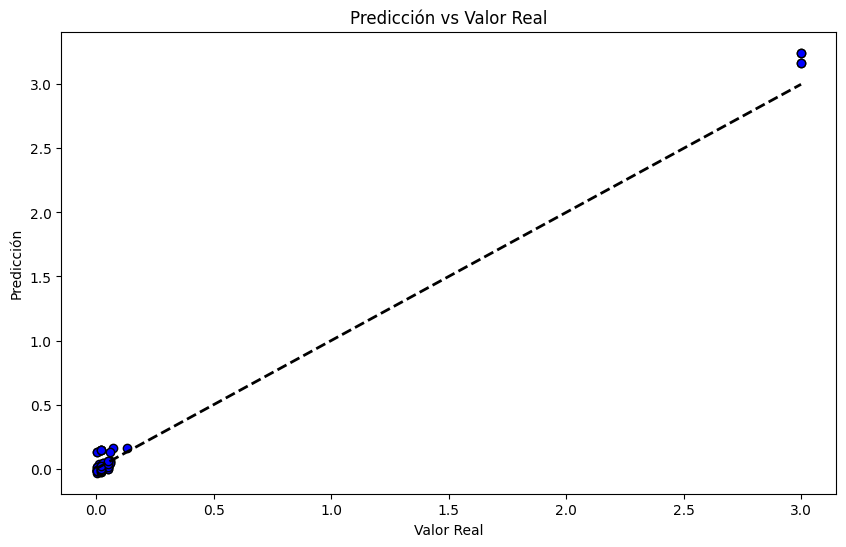

In [ ]:

# Visualización de Predicciones vs Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicción vs Valor Real')
plt.show()

In [ ]:
# Evaluación con Validación Cruzada
cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mse_cv = -cv_scores.mean()
print(f'MSE de Validación Cruzada: {mse_cv:.2f}')

MSE de Validación Cruzada: 0.00


In [ ]:
# Ajuste de Hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Mejor modelo: {best_model}')

Mejor modelo: MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50), max_iter=1000,
             random_state=42)
